# Simple q-learning agent with experience replay

We re-write q-learning algorithm using _agentnet_ - a helper for lasagne that implements some RL techniques.

In [1]:
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

#XVFB will be launched if you run on a server
import os
if type(os.environ.get("DISPLAY")) is not str or len(os.environ.get("DISPLAY"))==0:
    !bash ../xvfb start
    %env DISPLAY=:1

Starting virtual X frame buffer: Xvfb../xvfb: line 8: start-stop-daemon: command not found
.
env: DISPLAY=:1


### Experiment setup
* Here we simply load the game and check that it works

In [2]:
import gym
make_env = lambda: gym.make("Acrobot-v1")

env=make_env()
env.reset()

state_shape = env.observation_space.shape
n_actions = env.action_space.n

[2017-05-05 17:19:06,702] Making new env: Acrobot-v1


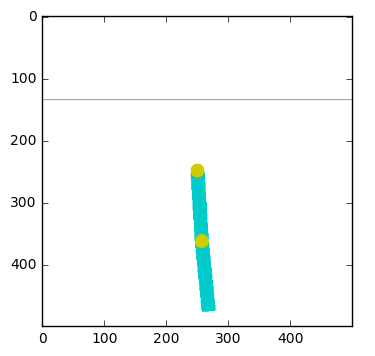

In [3]:
plt.imshow(env.render("rgb_array"))
del env

# Neural Network body

In [7]:
(None, None,) + state_shape

(None, None, 6)

In [9]:
import lasagne
from lasagne.layers import *
from lasagne.nonlinearities import elu

#image observation at current tick goes here, shape = (sample_i,x,y,color)
#<define a network layer here. We recommend 2-3 layers of 100~300 neurons for
observation_layer = InputLayer((None,)+state_shape)
d_layer = DenseLayer(observation_layer, 256, nonlinearity=elu)
d_layer2 = DenseLayer(d_layer, 64, nonlinearity=elu)
d_layer3 = DenseLayer(d_layer2, 256, nonlinearity=elu)
#nn = LSTMLayer(observation_layer, 128, nonlinearity=elu)

#a layer that predicts Qvalues
qvalues_layer = DenseLayer(d_layer3, num_units=n_actions, nonlinearity=None, name="q-values")

Picking actions is done by yet another layer, that implements $ \epsilon$ -greedy policy

In [10]:
from agentnet.resolver import EpsilonGreedyResolver
action_layer = EpsilonGreedyResolver(qvalues_layer)

#set starting epsilon
action_layer.epsilon.set_value(np.float32(0.05))


### Agent

We define an agent entirely composed of a lasagne network:
* Observations as InputLayer(s)
* Actions as intermediate Layer(s)
* `policy_estimators` is "whatever else you want to keep track of"

Each parameter can be either one layer or a list of layers

In [11]:
from agentnet.agent import Agent
agent = Agent(observation_layers=observation_layer,
              action_layers=action_layer,
              policy_estimators=qvalues_layer,)


In [12]:
#Since it's a single lasagne network, one can get it's weights, output, etc
weights = lasagne.layers.get_all_params(action_layer,trainable=True)
weights

[W, b, W, b, W, b, q-values.W, q-values.b]

# Create and manage a pool of atari sessions to play with

* To make training more stable, we shall have an entire batch of game sessions each happening independent of others
* Why several parallel agents help training: http://arxiv.org/pdf/1602.01783v1.pdf
* Alternative approach: store more sessions: https://www.cs.toronto.edu/~vmnih/docs/dqn.pdf

In [13]:
from agentnet.experiments.openai_gym.pool import EnvPool
pool = EnvPool(agent,make_env,n_games=1,max_size=10000)

[2017-05-05 17:22:52,750] Making new env: Acrobot-v1


In [14]:
%%time
#interact for 7 ticks
obs_log,action_log,reward_log,_,_,_  = pool.interact(5)


print('actions:',action_log)
print('rewards:',reward_log)

('actions:', array([[0, 2, 2, 0, 0]]))
('rewards:', array([[-1., -1., -1., -1.,  0.]]))
CPU times: user 5.45 ms, sys: 2.34 ms, total: 7.79 ms
Wall time: 8.79 ms


In [15]:
#we'll train on rollouts of 10 steps (required by n-step algorithms and rnns later)
SEQ_LENGTH=10

#load first sessions (this function calls interact and stores sessions in the pool)

for _ in range(100):
    pool.update(SEQ_LENGTH, append=True)

/Users/oleg/Anaconda/envs/py2/lib/python2.7/site-packages/agentnet/utils/logging.py:14: UserWarning: [Verbose>=1] Warning! Appending sessions to empty or broken pool. Old pool sessions, if any, are disposed.
  default_warn("[Verbose>=%s] %s"%(verbosity_level,message),**kwargs)


In [16]:
#pool.experience_replay[0].get_value()

# q-learning

We shall now define a function that replays recent game sessions and updates network weights

In [17]:
#get agent's Qvalues obtained via experience replay
replay = pool.experience_replay.sample_session_batch(100)
qvalues_seq = agent.get_sessions(
    replay,
    session_length=SEQ_LENGTH,
    experience_replay=True,
)[-1]



In [18]:
#loss for Qlearning = (Q(s,a) - (r+gamma*Q(s',a_max)))^2, like you implemented before in lasagne.

from agentnet.learning import qlearning
elwise_mse_loss = qlearning.get_elementwise_objective(qvalues_seq,
                                                      replay.actions[0],
                                                      replay.rewards,
                                                      replay.is_alive,
                                                      gamma_or_gammas=0.99,
                                                      n_steps=1,)

#compute mean loss over "alive" fragments
loss = elwise_mse_loss.sum() / replay.is_alive.sum()

In [19]:
#get weight updates
updates = lasagne.updates.adam(loss,weights,learning_rate=1e-4)

#compile train function
import theano
train_step = theano.function([],loss,updates=updates)

# Demo run

Play full session with an untrained agent

In [20]:
#for MountainCar-v0 evaluation session is cropped to 200 ticks
untrained_reward = pool.evaluate(save_path="./records",record_video=True)

[2017-05-05 17:23:40,032] Making new env: Acrobot-v1
[2017-05-05 17:23:40,041] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:23:40,043] Creating monitor directory ./records
[2017-05-05 17:23:40,046] Starting new video recorder writing to /Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records/openaigym.video.0.66732.video000000.mp4
[2017-05-05 17:23:45,641] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 500 timesteps with reward=-500.0


In [22]:
#show video
from IPython.display import HTML
import os

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

HTML("""
<video width="640" height="480" controls>
  <source src="{}" type="video/mp4">
</video>
""".format("./records/"+video_names[-1])) #this may or may not be _last_ video. Try other indices

# Training loop

In [23]:
epoch_counter = 1 #starting epoch
rewards = {} #full game rewards

In [24]:
from tqdm import trange

target_score = 100

for i in trange(5000):    
    
    #play
    for _ in range(5):
        pool.update(SEQ_LENGTH,append=True)
    
    #train
    train_step()
    
    #update epsilon
    epsilon = 0.05 + 0.95*np.exp(-epoch_counter/1000.)
    action_layer.epsilon.set_value(np.float32(epsilon))
    
    #play a few games for evaluation
    if epoch_counter%100==0:
        rewards[epoch_counter] = np.mean(pool.evaluate(n_games=3,record_video=False))
        print("iter=%i\tepsilon=%.3f"%(epoch_counter,action_layer.epsilon.get_value(),))
        print("Current score(mean over %i) = %.3f"%(3,np.mean(rewards[epoch_counter])))
    
        if rewards[epoch_counter] >= target_score:
            print("You win!")
            break

    
    epoch_counter  +=1

    
# Time to drink some coffee!

  2%|▏         | 99/5000 [00:04<03:52, 21.08it/s][2017-05-05 17:24:51,511] Making new env: Acrobot-v1
[2017-05-05 17:24:51,519] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:24:51,520] Clearing 4 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-05-05 17:24:52,097] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
  2%|▏         | 102/5000 [00:05<08:49,  9.25it/s]

Episode finished after 500 timesteps with reward=-500.0
iter=100	epsilon=0.910
Current score(mean over 3) = -500.000


  4%|▍         | 198/5000 [00:10<03:49, 20.96it/s][2017-05-05 17:24:57,311] Making new env: Acrobot-v1
[2017-05-05 17:24:57,318] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:24:57,319] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-05-05 17:24:58,012] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
  4%|▍         | 201/5000 [00:11<09:34,  8.35it/s]

Episode finished after 500 timesteps with reward=-500.0
iter=200	epsilon=0.828
Current score(mean over 3) = -500.000


  6%|▌         | 297/5000 [00:16<03:59, 19.64it/s][2017-05-05 17:25:03,362] Making new env: Acrobot-v1
[2017-05-05 17:25:03,371] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:03,373] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-05-05 17:25:03,859] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
  6%|▌         | 302/5000 [00:17<06:37, 11.82it/s]

Episode finished after 417 timesteps with reward=-416.0
iter=300	epsilon=0.754
Current score(mean over 3) = -472.000


  8%|▊         | 399/5000 [00:23<04:32, 16.89it/s][2017-05-05 17:25:10,387] Making new env: Acrobot-v1
[2017-05-05 17:25:10,395] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:10,396] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:25:10,672] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 244 timesteps with reward=-243.0
Episode finished after 241 timesteps with reward=-240.0
Episode finished after 231 timesteps with reward=-230.0
iter=400	epsilon=0.687
Current score(mean over 3) = -237.667


 10%|▉         | 499/5000 [00:29<04:25, 16.98it/s][2017-05-05 17:25:16,419] Making new env: Acrobot-v1
[2017-05-05 17:25:16,428] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:16,429] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 197 timesteps with reward=-196.0
Episode finished after 372 timesteps with reward=-371.0


[2017-05-05 17:25:16,747] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 10%|█         | 503/5000 [00:30<06:53, 10.88it/s]

Episode finished after 224 timesteps with reward=-223.0
iter=500	epsilon=0.626
Current score(mean over 3) = -263.333


 12%|█▏        | 599/5000 [00:37<04:34, 16.03it/s][2017-05-05 17:25:23,880] Making new env: Acrobot-v1
[2017-05-05 17:25:23,889] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:23,890] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:25:24,150] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 260 timesteps with reward=-259.0
Episode finished after 194 timesteps with reward=-193.0
Episode finished after 196 timesteps with reward=-195.0
iter=600	epsilon=0.571
Current score(mean over 3) = -215.667


 14%|█▍        | 699/5000 [00:44<05:28, 13.08it/s][2017-05-05 17:25:30,830] Making new env: Acrobot-v1
[2017-05-05 17:25:30,839] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:30,840] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 140 timesteps with reward=-139.0
Episode finished after 208 timesteps with reward=-207.0


[2017-05-05 17:25:31,295] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 14%|█▍        | 701/5000 [00:44<10:56,  6.55it/s]

Episode finished after 314 timesteps with reward=-313.0
iter=700	epsilon=0.522
Current score(mean over 3) = -219.667


 16%|█▌        | 799/5000 [00:51<04:48, 14.57it/s][2017-05-05 17:25:38,082] Making new env: Acrobot-v1
[2017-05-05 17:25:38,092] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:38,094] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:25:38,374] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 154 timesteps with reward=-153.0
Episode finished after 248 timesteps with reward=-247.0
Episode finished after 199 timesteps with reward=-198.0
iter=800	epsilon=0.477
Current score(mean over 3) = -199.333


 18%|█▊        | 899/5000 [00:57<04:04, 16.75it/s][2017-05-05 17:25:44,500] Making new env: Acrobot-v1
[2017-05-05 17:25:44,508] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:44,509] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:25:44,705] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 18%|█▊        | 901/5000 [00:58<06:09, 11.08it/s]

Episode finished after 157 timesteps with reward=-156.0
Episode finished after 159 timesteps with reward=-158.0
Episode finished after 221 timesteps with reward=-220.0
iter=900	epsilon=0.436
Current score(mean over 3) = -178.000


 20%|█▉        | 998/5000 [01:07<08:20,  8.00it/s][2017-05-05 17:25:54,557] Making new env: Acrobot-v1
[2017-05-05 17:25:54,565] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:25:54,566] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:25:54,759] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 20%|██        | 1000/5000 [01:08<09:22,  7.11it/s]

Episode finished after 165 timesteps with reward=-164.0
Episode finished after 114 timesteps with reward=-113.0
Episode finished after 174 timesteps with reward=-173.0
iter=1000	epsilon=0.399
Current score(mean over 3) = -150.000


 22%|██▏       | 1098/5000 [01:15<04:43, 13.74it/s][2017-05-05 17:26:02,198] Making new env: Acrobot-v1
[2017-05-05 17:26:02,206] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:26:02,207] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:26:02,351] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 22%|██▏       | 1100/5000 [01:15<06:14, 10.42it/s]

Episode finished after 122 timesteps with reward=-121.0
Episode finished after 139 timesteps with reward=-138.0
Episode finished after 96 timesteps with reward=-95.0
iter=1100	epsilon=0.366
Current score(mean over 3) = -118.000


 24%|██▍       | 1199/5000 [01:23<06:28,  9.77it/s][2017-05-05 17:26:10,252] Making new env: Acrobot-v1
[2017-05-05 17:26:10,259] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:26:10,260] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:26:10,433] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 24%|██▍       | 1201/5000 [01:23<07:48,  8.10it/s]

Episode finished after 167 timesteps with reward=-166.0
Episode finished after 117 timesteps with reward=-116.0
Episode finished after 155 timesteps with reward=-154.0
iter=1200	epsilon=0.336
Current score(mean over 3) = -145.333


 26%|██▌       | 1299/5000 [01:32<08:05,  7.62it/s][2017-05-05 17:26:19,528] Making new env: Acrobot-v1
[2017-05-05 17:26:19,537] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:26:19,539] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:26:19,723] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 26%|██▌       | 1300/5000 [01:33<11:44,  5.25it/s]

Episode finished after 160 timesteps with reward=-159.0
Episode finished after 103 timesteps with reward=-102.0
Episode finished after 120 timesteps with reward=-119.0
iter=1300	epsilon=0.309
Current score(mean over 3) = -126.667


 28%|██▊       | 1399/5000 [01:40<04:23, 13.66it/s][2017-05-05 17:26:27,498] Making new env: Acrobot-v1
[2017-05-05 17:26:27,505] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:26:27,506] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:26:27,628] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 28%|██▊       | 1401/5000 [01:41<05:33, 10.79it/s]

Episode finished after 134 timesteps with reward=-133.0
Episode finished after 119 timesteps with reward=-118.0
Episode finished after 79 timesteps with reward=-78.0
iter=1400	epsilon=0.284
Current score(mean over 3) = -109.667


 30%|██▉       | 1499/5000 [01:48<04:27, 13.10it/s][2017-05-05 17:26:35,139] Making new env: Acrobot-v1
[2017-05-05 17:26:35,148] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:26:35,149] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:26:35,401] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 252 timesteps with reward=-251.0
Episode finished after 190 timesteps with reward=-189.0
Episode finished after 280 timesteps with reward=-279.0
iter=1500	epsilon=0.262
Current score(mean over 3) = -239.667


 32%|███▏      | 1599/5000 [01:58<07:30,  7.55it/s][2017-05-05 17:26:45,587] Making new env: Acrobot-v1
[2017-05-05 17:26:45,597] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:26:45,599] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 236 timesteps with reward=-235.0
Episode finished after 197 timesteps with reward=-196.0


[2017-05-05 17:26:46,030] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 32%|███▏      | 1601/5000 [01:59<12:28,  4.54it/s]

Episode finished after 297 timesteps with reward=-296.0
iter=1600	epsilon=0.242
Current score(mean over 3) = -242.333


 34%|███▍      | 1699/5000 [02:10<06:45,  8.14it/s][2017-05-05 17:26:57,357] Making new env: Acrobot-v1
[2017-05-05 17:26:57,367] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:26:57,370] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 162 timesteps with reward=-161.0


[2017-05-05 17:26:57,805] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 34%|███▍      | 1700/5000 [02:11<14:54,  3.69it/s]

Episode finished after 265 timesteps with reward=-264.0
Episode finished after 167 timesteps with reward=-166.0
iter=1700	epsilon=0.224
Current score(mean over 3) = -197.000


 36%|███▌      | 1799/5000 [02:23<06:44,  7.90it/s][2017-05-05 17:27:10,300] Making new env: Acrobot-v1
[2017-05-05 17:27:10,309] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:27:10,311] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 366 timesteps with reward=-365.0
Episode finished after 314 timesteps with reward=-313.0


[2017-05-05 17:27:10,800] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 36%|███▌      | 1801/5000 [02:24<12:04,  4.42it/s]

Episode finished after 398 timesteps with reward=-397.0
iter=1800	epsilon=0.207
Current score(mean over 3) = -358.333


 38%|███▊      | 1899/5000 [02:34<06:00,  8.59it/s][2017-05-05 17:27:21,175] Making new env: Acrobot-v1
[2017-05-05 17:27:21,183] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:27:21,185] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:27:21,441] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 38%|███▊      | 1900/5000 [02:34<10:03,  5.14it/s]

Episode finished after 247 timesteps with reward=-246.0
Episode finished after 144 timesteps with reward=-143.0
Episode finished after 212 timesteps with reward=-211.0
iter=1900	epsilon=0.192
Current score(mean over 3) = -200.000


 40%|███▉      | 1999/5000 [02:46<07:20,  6.81it/s][2017-05-05 17:27:33,114] Making new env: Acrobot-v1
[2017-05-05 17:27:33,122] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:27:33,123] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:27:33,250] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 40%|████      | 2000/5000 [02:46<08:37,  5.80it/s]

Episode finished after 110 timesteps with reward=-109.0
Episode finished after 110 timesteps with reward=-109.0
Episode finished after 138 timesteps with reward=-137.0
iter=2000	epsilon=0.179
Current score(mean over 3) = -118.333


 42%|████▏     | 2098/5000 [02:57<04:41, 10.32it/s][2017-05-05 17:27:43,900] Making new env: Acrobot-v1
[2017-05-05 17:27:43,908] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:27:43,910] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:27:44,057] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 42%|████▏     | 2100/5000 [02:57<05:41,  8.50it/s]

Episode finished after 89 timesteps with reward=-88.0
Episode finished after 170 timesteps with reward=-169.0
Episode finished after 119 timesteps with reward=-118.0
iter=2100	epsilon=0.166
Current score(mean over 3) = -125.000


 44%|████▍     | 2198/5000 [03:07<04:16, 10.93it/s][2017-05-05 17:27:53,894] Making new env: Acrobot-v1
[2017-05-05 17:27:53,901] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:27:53,903] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:27:54,185] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 44%|████▍     | 2200/5000 [03:07<06:20,  7.36it/s]

Episode finished after 366 timesteps with reward=-365.0
Episode finished after 232 timesteps with reward=-231.0
Episode finished after 127 timesteps with reward=-126.0
iter=2200	epsilon=0.155
Current score(mean over 3) = -240.667


 46%|████▌     | 2298/5000 [03:16<03:57, 11.40it/s][2017-05-05 17:28:03,606] Making new env: Acrobot-v1
[2017-05-05 17:28:03,614] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:28:03,615] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 200 timesteps with reward=-199.0
Episode finished after 215 timesteps with reward=-214.0


[2017-05-05 17:28:03,941] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 46%|████▌     | 2300/5000 [03:17<06:11,  7.26it/s]

Episode finished after 261 timesteps with reward=-260.0
iter=2300	epsilon=0.145
Current score(mean over 3) = -224.333


 48%|████▊     | 2398/5000 [03:26<03:35, 12.05it/s][2017-05-05 17:28:13,621] Making new env: Acrobot-v1
[2017-05-05 17:28:13,629] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:28:13,630] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 292 timesteps with reward=-291.0
Episode finished after 390 timesteps with reward=-389.0


[2017-05-05 17:28:14,091] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 48%|████▊     | 2402/5000 [03:27<05:53,  7.34it/s]

Episode finished after 495 timesteps with reward=-494.0
iter=2400	epsilon=0.136
Current score(mean over 3) = -391.333


 50%|████▉     | 2498/5000 [03:35<03:24, 12.21it/s][2017-05-05 17:28:22,460] Making new env: Acrobot-v1
[2017-05-05 17:28:22,468] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:28:22,469] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 285 timesteps with reward=-284.0
Episode finished after 388 timesteps with reward=-387.0


[2017-05-05 17:28:22,877] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 50%|█████     | 2502/5000 [03:36<05:24,  7.69it/s]

Episode finished after 496 timesteps with reward=-495.0
iter=2500	epsilon=0.128
Current score(mean over 3) = -388.667


 52%|█████▏    | 2599/5000 [03:45<03:19, 12.02it/s][2017-05-05 17:28:31,831] Making new env: Acrobot-v1
[2017-05-05 17:28:31,839] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:28:31,840] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:28:32,066] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 52%|█████▏    | 2601/5000 [03:45<04:46,  8.39it/s]

Episode finished after 320 timesteps with reward=-319.0
Episode finished after 164 timesteps with reward=-163.0
Episode finished after 134 timesteps with reward=-133.0
iter=2600	epsilon=0.121
Current score(mean over 3) = -205.000


 54%|█████▍    | 2699/5000 [03:53<03:10, 12.10it/s][2017-05-05 17:28:40,355] Making new env: Acrobot-v1
[2017-05-05 17:28:40,363] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:28:40,364] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:28:40,466] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 54%|█████▍    | 2701/5000 [03:53<03:49, 10.03it/s]

Episode finished after 88 timesteps with reward=-87.0
Episode finished after 103 timesteps with reward=-102.0
Episode finished after 77 timesteps with reward=-76.0
iter=2700	epsilon=0.114
Current score(mean over 3) = -88.333


 56%|█████▌    | 2799/5000 [04:02<03:02, 12.08it/s][2017-05-05 17:28:48,770] Making new env: Acrobot-v1
[2017-05-05 17:28:48,778] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:28:48,779] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:28:48,921] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 56%|█████▌    | 2801/5000 [04:02<03:54,  9.39it/s]

Episode finished after 103 timesteps with reward=-102.0
Episode finished after 146 timesteps with reward=-145.0
Episode finished after 135 timesteps with reward=-134.0
iter=2800	epsilon=0.108
Current score(mean over 3) = -127.000


 58%|█████▊    | 2898/5000 [04:12<03:38,  9.61it/s][2017-05-05 17:28:59,034] Making new env: Acrobot-v1
[2017-05-05 17:28:59,041] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:28:59,043] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:28:59,337] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 58%|█████▊    | 2900/5000 [04:12<05:02,  6.95it/s]

Episode finished after 401 timesteps with reward=-400.0
Episode finished after 159 timesteps with reward=-158.0
Episode finished after 135 timesteps with reward=-134.0
iter=2900	epsilon=0.102
Current score(mean over 3) = -230.667


 60%|█████▉    | 2998/5000 [04:20<02:45, 12.10it/s][2017-05-05 17:29:07,704] Making new env: Acrobot-v1
[2017-05-05 17:29:07,711] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:29:07,713] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:29:07,962] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 60%|██████    | 3000/5000 [04:21<04:02,  8.24it/s]

Episode finished after 169 timesteps with reward=-168.0
Episode finished after 264 timesteps with reward=-263.0
Episode finished after 276 timesteps with reward=-275.0
iter=3000	epsilon=0.097
Current score(mean over 3) = -235.333


 62%|██████▏   | 3098/5000 [04:29<02:37, 12.06it/s][2017-05-05 17:29:16,583] Making new env: Acrobot-v1
[2017-05-05 17:29:16,591] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:29:16,592] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:29:16,845] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 62%|██████▏   | 3100/5000 [04:30<03:52,  8.19it/s]

Episode finished after 190 timesteps with reward=-189.0
Episode finished after 192 timesteps with reward=-191.0
Episode finished after 314 timesteps with reward=-313.0
iter=3100	epsilon=0.093
Current score(mean over 3) = -231.000


 64%|██████▍   | 3199/5000 [04:39<02:42, 11.07it/s][2017-05-05 17:29:25,791] Making new env: Acrobot-v1
[2017-05-05 17:29:25,799] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:29:25,801] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 500 timesteps with reward=-500.0


[2017-05-05 17:29:26,292] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 64%|██████▍   | 3201/5000 [04:39<04:58,  6.03it/s]

Episode finished after 397 timesteps with reward=-396.0
iter=3200	epsilon=0.089
Current score(mean over 3) = -465.333


 66%|██████▌   | 3299/5000 [04:49<02:38, 10.70it/s][2017-05-05 17:29:36,043] Making new env: Acrobot-v1
[2017-05-05 17:29:36,051] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:29:36,053] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 354 timesteps with reward=-353.0


[2017-05-05 17:29:36,521] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 66%|██████▌   | 3301/5000 [04:49<04:49,  5.87it/s]

Episode finished after 397 timesteps with reward=-396.0
iter=3300	epsilon=0.085
Current score(mean over 3) = -416.333


 68%|██████▊   | 3399/5000 [04:59<02:33, 10.43it/s][2017-05-05 17:29:46,505] Making new env: Acrobot-v1
[2017-05-05 17:29:46,512] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:29:46,513] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:29:46,739] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 222 timesteps with reward=-221.0
Episode finished after 297 timesteps with reward=-296.0
Episode finished after 97 timesteps with reward=-96.0
iter=3400	epsilon=0.082
Current score(mean over 3) = -204.333


 70%|██████▉   | 3498/5000 [05:09<02:20, 10.67it/s][2017-05-05 17:29:56,334] Making new env: Acrobot-v1
[2017-05-05 17:29:56,344] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:29:56,346] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:29:56,591] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 70%|███████   | 3500/5000 [05:09<03:14,  7.70it/s]

Episode finished after 232 timesteps with reward=-231.0
Episode finished after 162 timesteps with reward=-161.0
Episode finished after 96 timesteps with reward=-95.0
iter=3500	epsilon=0.079
Current score(mean over 3) = -162.333


 72%|███████▏  | 3598/5000 [05:19<02:10, 10.72it/s][2017-05-05 17:30:06,678] Making new env: Acrobot-v1
[2017-05-05 17:30:06,686] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:30:06,687] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 169 timesteps with reward=-168.0


[2017-05-05 17:30:07,035] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 72%|███████▏  | 3600/5000 [05:20<03:22,  6.90it/s]

Episode finished after 480 timesteps with reward=-479.0
Episode finished after 183 timesteps with reward=-182.0
iter=3600	epsilon=0.076
Current score(mean over 3) = -276.333


 74%|███████▍  | 3698/5000 [05:30<02:20,  9.27it/s][2017-05-05 17:30:17,133] Making new env: Acrobot-v1
[2017-05-05 17:30:17,141] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:30:17,142] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 101 timesteps with reward=-100.0
Episode finished after 500 timesteps with reward=-500.0

[2017-05-05 17:30:17,489] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 74%|███████▍  | 3702/5000 [05:31<02:56,  7.35it/s]


Episode finished after 249 timesteps with reward=-248.0
iter=3700	epsilon=0.073
Current score(mean over 3) = -282.667


 76%|███████▌  | 3799/5000 [05:40<01:53, 10.55it/s][2017-05-05 17:30:27,065] Making new env: Acrobot-v1
[2017-05-05 17:30:27,073] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:30:27,074] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:30:27,324] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 308 timesteps with reward=-307.0
Episode finished after 160 timesteps with reward=-159.0
Episode finished after 156 timesteps with reward=-155.0
iter=3800	epsilon=0.071
Current score(mean over 3) = -207.000


 78%|███████▊  | 3898/5000 [05:50<01:32, 11.92it/s][2017-05-05 17:30:36,817] Making new env: Acrobot-v1
[2017-05-05 17:30:36,825] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:30:36,826] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:30:37,014] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 78%|███████▊  | 3900/5000 [05:50<02:05,  8.79it/s]

Episode finished after 100 timesteps with reward=-99.0
Episode finished after 326 timesteps with reward=-325.0
Episode finished after 102 timesteps with reward=-101.0
iter=3900	epsilon=0.069
Current score(mean over 3) = -175.000


 80%|███████▉  | 3998/5000 [05:58<01:22, 12.12it/s][2017-05-05 17:30:45,424] Making new env: Acrobot-v1
[2017-05-05 17:30:45,431] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:30:45,433] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:30:45,716] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 80%|████████  | 4000/5000 [05:59<02:05,  7.94it/s]

Episode finished after 251 timesteps with reward=-250.0
Episode finished after 321 timesteps with reward=-320.0
Episode finished after 227 timesteps with reward=-226.0
iter=4000	epsilon=0.067
Current score(mean over 3) = -265.333


 82%|████████▏ | 4099/5000 [06:08<01:24, 10.60it/s][2017-05-05 17:30:54,950] Making new env: Acrobot-v1
[2017-05-05 17:30:54,958] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:30:54,959] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:30:55,169] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')


Episode finished after 170 timesteps with reward=-169.0
Episode finished after 166 timesteps with reward=-165.0
Episode finished after 146 timesteps with reward=-145.0
iter=4100	epsilon=0.066
Current score(mean over 3) = -159.667


 84%|████████▍ | 4199/5000 [06:17<01:16, 10.48it/s][2017-05-05 17:31:04,370] Making new env: Acrobot-v1
[2017-05-05 17:31:04,377] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:31:04,379] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:31:04,488] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 84%|████████▍ | 4201/5000 [06:17<01:28,  9.00it/s]

Episode finished after 109 timesteps with reward=-108.0
Episode finished after 98 timesteps with reward=-97.0
Episode finished after 77 timesteps with reward=-76.0
iter=4200	epsilon=0.064
Current score(mean over 3) = -93.667


 86%|████████▌ | 4298/5000 [06:27<01:08, 10.21it/s][2017-05-05 17:31:14,388] Making new env: Acrobot-v1
[2017-05-05 17:31:14,395] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:31:14,397] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:31:14,559] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 86%|████████▌ | 4300/5000 [06:27<01:24,  8.33it/s]

Episode finished after 87 timesteps with reward=-86.0
Episode finished after 84 timesteps with reward=-83.0
Episode finished after 110 timesteps with reward=-109.0
iter=4300	epsilon=0.063
Current score(mean over 3) = -92.667


 88%|████████▊ | 4398/5000 [06:37<00:59, 10.07it/s][2017-05-05 17:31:24,362] Making new env: Acrobot-v1
[2017-05-05 17:31:24,371] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:31:24,373] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:31:24,580] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 88%|████████▊ | 4400/5000 [06:37<01:24,  7.14it/s]

Episode finished after 84 timesteps with reward=-83.0
Episode finished after 86 timesteps with reward=-85.0
Episode finished after 86 timesteps with reward=-85.0
iter=4400	epsilon=0.062
Current score(mean over 3) = -84.333


 90%|████████▉ | 4498/5000 [06:47<00:55,  9.03it/s][2017-05-05 17:31:34,842] Making new env: Acrobot-v1
[2017-05-05 17:31:34,852] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:31:34,854] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:31:35,064] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 90%|█████████ | 4500/5000 [06:48<01:11,  7.04it/s]

Episode finished after 77 timesteps with reward=-76.0
Episode finished after 147 timesteps with reward=-146.0
Episode finished after 83 timesteps with reward=-82.0
iter=4500	epsilon=0.061
Current score(mean over 3) = -101.333


 92%|█████████▏| 4598/5000 [06:57<00:33, 12.11it/s][2017-05-05 17:31:44,218] Making new env: Acrobot-v1
[2017-05-05 17:31:44,225] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:31:44,226] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:31:44,366] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 92%|█████████▏| 4600/5000 [06:57<00:42,  9.38it/s]

Episode finished after 130 timesteps with reward=-129.0
Episode finished after 114 timesteps with reward=-113.0
Episode finished after 116 timesteps with reward=-115.0
iter=4600	epsilon=0.060
Current score(mean over 3) = -119.000


 94%|█████████▍| 4698/5000 [07:05<00:24, 12.25it/s][2017-05-05 17:31:52,637] Making new env: Acrobot-v1
[2017-05-05 17:31:52,645] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:31:52,646] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:31:52,944] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 94%|█████████▍| 4700/5000 [07:06<00:38,  7.84it/s]

Episode finished after 225 timesteps with reward=-224.0
Episode finished after 240 timesteps with reward=-239.0
Episode finished after 363 timesteps with reward=-362.0
iter=4700	epsilon=0.059
Current score(mean over 3) = -275.000


 96%|█████████▌| 4799/5000 [07:15<00:21,  9.50it/s][2017-05-05 17:32:02,392] Making new env: Acrobot-v1
[2017-05-05 17:32:02,401] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:32:02,402] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:32:02,624] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 96%|█████████▌| 4800/5000 [07:15<00:34,  5.81it/s]

Episode finished after 139 timesteps with reward=-138.0
Episode finished after 131 timesteps with reward=-130.0
Episode finished after 113 timesteps with reward=-112.0
iter=4800	epsilon=0.058
Current score(mean over 3) = -126.667


 98%|█████████▊| 4899/5000 [07:25<00:10,  9.79it/s][2017-05-05 17:32:12,439] Making new env: Acrobot-v1
[2017-05-05 17:32:12,447] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:32:12,448] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-05-05 17:32:12,584] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
 98%|█████████▊| 4900/5000 [07:25<00:14,  6.92it/s]

Episode finished after 93 timesteps with reward=-92.0
Episode finished after 92 timesteps with reward=-91.0
Episode finished after 100 timesteps with reward=-99.0
iter=4900	epsilon=0.057
Current score(mean over 3) = -94.000


100%|█████████▉| 4998/5000 [07:36<00:00, 10.97it/s][2017-05-05 17:32:22,854] Making new env: Acrobot-v1
[2017-05-05 17:32:22,862] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-05-05 17:32:22,863] Clearing 2 monitor files from previous run (because force=True was provided)


Episode finished after 457 timesteps with reward=-456.0
Episode finished after 273 timesteps with reward=-272.0


[2017-05-05 17:32:23,301] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Documents/Homeworks/rl/reinforcement_learning/week4/records')
100%|██████████| 5000/5000 [07:36<00:00,  6.41it/s]

Episode finished after 500 timesteps with reward=-500.0
iter=5000	epsilon=0.056
Current score(mean over 3) = -409.333


In [ ]:
from pandas import ewma
iters,session_rewards=zip(*sorted(rewards.items(),key=lambda (k,v):k))
plt.plot(iters,ewma(np.array(session_rewards),span=10))

In [40]:
final_reward = pool.evaluate(n_games=10,save_path="./records",record_video=True)

print("average reward:",final_reward)

video_names = list(filter(lambda s:s.endswith(".mp4"),os.listdir("./records/")))

for video_name in video_names:
    HTML("""
    <video width="640" height="480" controls>
      <source src="{}" type="video/mp4">
    </video>
    """.format("./records/"+video_name)) #this may or may not be _last_ video. Try other indices

[2017-02-28 01:44:13,614] Making new env: Acrobot-v1
[2017-02-28 01:44:13,624] DEPRECATION WARNING: env.spec.timestep_limit has been deprecated. Replace your call to `env.spec.timestep_limit` with `env.spec.tags.get('wrapper_config.TimeLimit.max_episode_steps')`. This change was made 12/28/2016 and is included in version 0.7.0
[2017-02-28 01:44:13,626] Clearing 2 monitor files from previous run (because force=True was provided)
[2017-02-28 01:44:13,629] Starting new video recorder writing to /Users/oleg/Dropbox/Homeworks/rl/rl_w4/week4/records/openaigym.video.23.63032.video000000.mp4
[2017-02-28 01:44:16,865] Starting new video recorder writing to /Users/oleg/Dropbox/Homeworks/rl/rl_w4/week4/records/openaigym.video.23.63032.video000001.mp4


Episode finished after 255 timesteps with reward=-254.0
Episode finished after 218 timesteps with reward=-217.0
Episode finished after 249 timesteps with reward=-248.0
Episode finished after 270 timesteps with reward=-269.0
Episode finished after 180 timesteps with reward=-179.0
Episode finished after 318 timesteps with reward=-317.0
Episode finished after 170 timesteps with reward=-169.0


[2017-02-28 01:44:20,456] Starting new video recorder writing to /Users/oleg/Dropbox/Homeworks/rl/rl_w4/week4/records/openaigym.video.23.63032.video000008.mp4


Episode finished after 500 timesteps with reward=-500.0
Episode finished after 240 timesteps with reward=-239.0


[2017-02-28 01:44:23,842] Finished writing results. You can upload them to the scoreboard via gym.upload('/Users/oleg/Dropbox/Homeworks/rl/rl_w4/week4/records')


Episode finished after 364 timesteps with reward=-363.0
('average reward:', [-254.0, -217.0, -248.0, -269.0, -179.0, -317.0, -169.0, -500.0, -239.0, -363.0])


## Homework part I (5+ pts)

Train a neural network for [`LunarLander-v2`](https://gym.openai.com/envs/LunarLander-v2).
* Getting average reward of at least +0 gets you 5 points
* Higher reward = more points


## Bonus I
* Try getting the same [or better] results on Acrobot __(+2 pts)__ or __LunarLander (+3 pts)__ using on-policy methods
* You can get n-step q-learning by messing with ```n_steps``` param in the q-learning code above
* Note that using large experience replay buffer will slow down on-policy algorithms to almost zero, so it's probably a good idea to use small experience replay buffer with several parallel agents